In [13]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from torch.nn.parameter import Parameter
import matplotlib as mpl

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io
from scipy.io import savemat

from smt.sampling_methods import LHS

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda':
    print(torch.cuda.get_device_name())


cuda:0


In [2]:
def true_2D_2(xy): #True function for 2D_2 Helmholtz equation (x,y) \in [-1,1]
    term1 = (xy[:,0] + xy[:,1]).reshape(-1,1)
    term2 = np.sin(np.pi*xy[:,0]).reshape(-1,1)
    term3 = np.sin(np.pi*xy[:,1]).reshape(-1,1)
    
    u = term1*term2*term3
    
    return u.reshape(-1,1)    

In [3]:
loss_thresh = 0.1
label = "HH_stan"


x_ll = -1.0
x_ul = 1.0
y_ll = -1.0
y_ul = 1.0

pi = torch.from_numpy(np.array(np.pi)).double().to(device)

x = np.linspace(x_ll,x_ul,500).reshape(-1,1)
y = np.linspace(y_ll,y_ul,500).reshape(-1,1)

X,Y = np.meshgrid(x,y)

X = X.flatten('F').reshape(-1,1)
Y = Y.flatten('F').reshape(-1,1)
  
xy = np.hstack((X,Y))

u_true = true_2D_2(xy)
u_true_norm = np.linalg.norm(u_true,2)
#bound_pts_idx = ((X == x_ll) + (X == x_ul) + (Y == y_ll) + (Y == y_ul)).reshape(-1,)

#xy_bound = xy[bound_pts_idx,:]
#u_bound = u_true[bound_pts_idx,:]


xy_test_tensor = torch.from_numpy(xy).float().to(device)


lb_xy = xy[0]
ub_xy = xy[-1]

In [14]:
def trainingdata(N_T,N_f,seed):
    '''Boundary Conditions''' 
    
    np.random.seed(seed)
    
    #choose random N_u points for training
    
    x_1 = np.random.uniform(x_ll,x_ul,(int(N_T/4),1))
    y_1 = y_ll*np.ones((int(N_T/4),1))
    x_2 = np.random.uniform(x_ll,x_ul,(int(N_T/4),1))
    y_2 = y_ul*np.ones((int(N_T/4),1))
    x_3 = x_ll*np.ones((int(N_T/4),1))
    y_3 = np.random.uniform(y_ll,y_ul,(int(N_T/4),1))
    x_4 = x_ul*np.ones((int(N_T/4),1))
    y_4 = np.random.uniform(y_ll,y_ul,(int(N_T/4),1))
    
    XY_1 = np.hstack((x_1,y_1))
    XY_2 = np.hstack((x_2,y_2))
    XY_3 = np.hstack((x_3,y_3))
    XY_4 = np.hstack((x_4,y_4))
    
    xy_BC = np.vstack((XY_1,XY_2,XY_3,XY_4)) #choose indices from  set 'idx' (x,t)
    u_BC = true_2D_2(xy_BC)      #choose corresponding u


    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
    x01 = np.array([[0.0,1.0],[0.0,1.0]])
    sampling = LHS(xlimits=x01,random_state =seed)
    samples = sampling(N_f)
    
    xy_coll = lb_xy + (ub_xy - lb_xy)*samples
    
    xy_coll = np.vstack((xy_coll, xy_BC)) # append training points to collocation points 

    return xy_coll, xy_BC, u_BC

In [15]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers,beta_init):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()

     
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        # std = gain * sqrt(2/(input_dim+output_dim))
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)
        
        self.beta = Parameter(beta_init*torch.ones((50,len(layers)-2)))
        self.beta.requiresGrad = True
        
    
    'foward pass'
    def forward(self,xy):
        if torch.is_tensor(xy) != True:         
            xy = torch.from_numpy(xy)                
        
        ubxy = torch.from_numpy(ub_xy).float().to(device)
        lbxy = torch.from_numpy(lb_xy).float().to(device)
    
                      
        #preprocessing input 
        xy = 2.0*(xy - lbxy)/(ubxy - lbxy)-1.0
        
        #convert to float
        a = xy.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            z1 = self.activation(z)
            a = z1 + self.beta[:,i]*z*z1
            
        a = self.linears[-1](a) 
         
        return a
                        
    def loss_BC(self,xy,u):
                
        loss_bc = self.loss_function(self.forward(xy), u)
                
        return loss_bc
    
    def loss_PDE(self, xy_coll, f_hat):
        
        g = xy_coll.clone()             
        g.requires_grad = True
        u = self.forward(g) 
    
        u_x_y = autograd.grad(u,g,torch.ones([xy_coll.shape[0], 1]).to(device), retain_graph=True, create_graph=True,allow_unused = True)[0]
        
        u_xx_yy = autograd.grad(u_x_y,g,torch.ones(xy_coll.shape).to(device), create_graph=True,allow_unused = True)[0]

        #du_dx = u_x_t[:,[0]]
        
        d2u_dx2 = u_xx_yy[:,[0]]
        d2u_dy2 = u_xx_yy[:,[1]]    
        

        f1 = d2u_dx2 + d2u_dy2 + 4.0*u
        
        
        f2 = 2.0*pi*torch.cos(pi*g[:,1].reshape(-1,1))*torch.sin(pi*g[:,0].reshape(-1,1)) + 2*pi*torch.cos(pi*g[:,0].reshape(-1,1))*torch.sin(pi*g[:,1].reshape(-1,1)) 
        f3 = 4.0*(g[:,0].reshape(-1,1)+g[:,1].reshape(-1,1))*torch.sin(pi*g[:,0].reshape(-1,1))*torch.sin(pi*g[:,1].reshape(-1,1)) 
        f4 = 2.0*torch.square(pi)*(g[:,0].reshape(-1,1)+g[:,1].reshape(-1,1))*torch.sin(pi*g[:,0].reshape(-1,1))*torch.sin(pi*g[:,1].reshape(-1,1))
        
        f = f1 - f2 -f3 +f4
        
        loss_f = self.loss_function(f,f_hat)
                
        return loss_f
    
    def loss(self,xy_BC,u_BC,xy_coll,f_hat):

        loss_BC = self.loss_BC(xy_BC,u_BC)
        loss_f = self.loss_PDE(xy_coll,f_hat)
        
        loss_val = loss_BC + loss_f
        
        return loss_val
     
    'callable for optimizer'                                       
    def closure(self):
        optimizer.zero_grad()
    
        loss = self.loss(xy_BC, u_BC, xy_coll,f_hat)
        self.train_loss.append(loss.cpu().detach().numpy())
        
        u_pred = self.test(xy_test_tensor)
        self.test_loss.append(np.mean(np.square(u_pred.reshape(-1,1) - u_true.reshape(-1,1))))
        rel_error = np.linalg.norm((u_pred.reshape(-1,1) - u_true.reshape(-1,1)),2)/np.linalg.norm(u_true.reshape(-1,1),2)
        self.beta_val.append(self.beta.cpu().detach().numpy())
        
        print(self.iter,"Train Loss",self.train_loss[-1],"Test Loss",self.test_loss[-1],'Rel Error',rel_error)
        
        loss.backward()
        self.iter += 1
  

        return loss        
    'test neural network'
    def test(self):
        u_pred = self.forward(xy_test_tensor)
        u_pred = u_pred.cpu().detach().numpy()
   
        return u_pred

    def test_loss(self):
        u_pred = self.test()
        
        test_mse = np.mean(np.square(u_pred.reshape(-1,1) - u_true.reshape(-1,1)))
        test_re = np.linalg.norm(u_pred.reshape(-1,1) - u_true.reshape(-1,1),2)/u_true_norm
        
        return test_mse, test_re 

In [16]:
def data_update(loss_np):
    train_loss.append(loss_np)
    beta_val.append(PINN.beta.cpu().detach().numpy())
    
    test_mse, test_re = PINN.test_loss()
    test_mse_loss.append(test_mse)
    test_re_loss.append(test_re)

In [17]:
def train_step(xy_BC,u_BC,xy_coll,f_hat,seed):

    def closure():
        optimizer.zero_grad()
        loss = PINN.loss(xy_BC,u_BC,xy_coll,f_hat)
        loss.backward()
        #print(loss.cpu().detach().numpy())
        return loss

    optimizer.step(closure)

In [18]:
def train_model(max_iter,rep): 
    print(rep) 
    torch.manual_seed(rep*9)
    start_time = time.time() 
    thresh_flag = 0

    xy_coll_np_array, xy_BC_np_array, u_BC_np_array = trainingdata(N_T,N_f,(reps+5)*22)
        
    xy_coll = torch.from_numpy(xy_coll_np_array).float().to(device)
    xy_BC = torch.from_numpy(xy_BC_np_array).float().to(device)
    u_BC = torch.from_numpy(u_BC_np_array).float().to(device)
        
    f_hat = torch.zeros(xy_coll.shape[0],1).to(device)
    

    for i in range(max_iter):
        train_step(xy_BC,u_BC,xy_coll,f_hat,i)
        loss_np = PINN.loss(xy_BC,u_BC,xy_coll,f_hat).cpu().detach().numpy()
        
        if(thresh_flag == 0):
            if(loss_np < loss_thresh):
                time_threshold[rep] = time.time() - start_time
                epoch_threshold[rep] = i+1          
                thresh_flag = 1       
        data_update(loss_np)
        
        print(i,"Train Loss",train_loss[-1],"Test MSE",test_mse_loss[-1],"Test RE",test_re_loss[-1])   
        
      
         

    elapsed_time[rep] = time.time() - start_time  
    print('Training time: %.2f' % (elapsed_time[rep]))

In [19]:
max_reps = 10 #10
max_iter = 100 #200

train_loss_full = []
test_mse_full = []
test_re_full = []
beta_full = []
elapsed_time= np.zeros((max_reps,1))
time_threshold = np.empty((max_reps,1))
time_threshold[:] = np.nan
epoch_threshold = max_iter*np.ones((max_reps,1))

beta_init = 1.0

N_T = 5000 #Total number of data points for BC
N_f = 50000 #Total number of collocation points 

#for reps in range(max_reps):
for reps in range(max_reps):
    print(label)
    print(reps)
    train_loss = []
    test_mse_loss = []
    test_re_loss = []
    beta_val = []
    
    torch.manual_seed(reps*36)
 
    layers = np.array([2,50,50,50,1]) #9 hidden layers
    

    PINN = Sequentialmodel(layers,beta_init)
   
    PINN.to(device)

    'Neural Network Summary'
    print(PINN)

    params = list(PINN.parameters())
    

    optimizer = torch.optim.LBFGS(PINN.parameters(), lr=1, 
                                      max_iter = 20, 
                                      max_eval = 30, 
                                      tolerance_grad = 1e-8, 
                                      tolerance_change = 1e-8, 
                                      history_size = 100, 
                                      line_search_fn = 'strong_wolfe')
    
    nan_flag = train_model(max_iter,reps)
    
    
    torch.save(PINN.state_dict(),label+'_'+str(reps)+'.pt')
    train_loss_full.append(train_loss)
    test_mse_full.append(test_mse_loss)
    test_re_full.append(test_re_loss)
    #elapsed_time[reps] = time.time() - start_time
    beta_full.append(beta_val)


    print('Training time: %.2f' % (elapsed_time[reps]))
    
mdic = {"train_loss": train_loss_full,"test_mse_loss": test_mse_full,"test_re_loss": test_re_full,"Time": elapsed_time, "beta": beta_full, "label": label,"Thresh Time": time_threshold,"Thresh epoch": epoch_threshold}
savemat(label+'.mat', mdic)

HH_stan
0
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=1, bias=True)
  )
)
0
0 Train Loss 3.8847668 Test MSE 0.5291816366465304 Test RE 1.9388529586150836
1 Train Loss 0.6966779 Test MSE 0.3644031076687129 Test RE 1.608916580032898
2 Train Loss 0.2870425 Test MSE 0.25245933602778714 Test RE 1.3391777004403707
3 Train Loss 0.15222797 Test MSE 0.15727757951399374 Test RE 1.0570022202057419
4 Train Loss 0.084804356 Test MSE 0.10597292307207384 Test RE 0.8676407638134239
5 Train Loss 0.054409087 Test MSE 0.08957328956616409 Test RE 0.7976856017477291
6 Train Loss 0.03872194 Test MSE 0.11854085370362166 Test RE 0.9176488325747317
7 Train Loss 0.029925218 Test MSE 0.11278778781796919 Test RE 0.8951040671191757
8 Train Loss 

KeyboardInterrupt: 

In [20]:
u_pred = PINN.test()

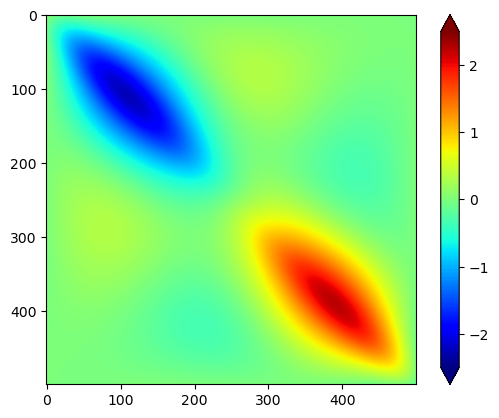

In [22]:
cmap = mpl.cm.jet
#norm = mpl.colors.Normalize(vmin=0, vmax=5)

fig,ax = plt.subplots()
img = ax.imshow(u_pred.reshape(500,500),vmin = -2.5,vmax = 2.5,cmap = cmap)
fig.colorbar(img,ax=ax, extend='both')

In [ ]:
cmap = mpl.cm.jet
fig,ax = plt.subplots()
img = ax.imshow(u_true.reshape(500,500),vmin = -10,vmax = 10,cmap = cmap)
fig.colorbar(img, ax=ax, extend='both')

In [ ]:
cmap = mpl.cm.jet
#norm = mpl.colors.Normalize(vmin=0, vmax=5)

fig,ax = plt.subplots()
img = ax.imshow(np.abs(u_pred-u_true).reshape(500,500),vmin = 0,vmax = 2,cmap = cmap)
fig.colorbar(img,ax=ax, extend='both')

In [ ]:
a = 0
for i in range(10):
    print(test_loss_full[i][-1])
    a = a + test_loss_full[i][-1]
print(a/10)